# Lecture code

Code for making the plots in the numpy Lecture for TUM Data Science course.

Nicole Hartman

$31^{st}$ Oct 2023

**Table of Contents**
1. [Vectorization Motivation](#vec-motivation)
- 1a) [Toy problem: Calculate $\pi$](#pi-mc)
- 1b) [Particle physics problem: classifier preprocessing](#bjet-ex)
2. [Array structures](#arr-struct)
- 2a) [Array creation](#arr-creation)
- 2b) [Interactive Q: Incidence Matrix calculation](#inc-mat)
- 2c) [Indexing](#index)
- 2d) [Filter maps](#filters)
- 2e) [Solve the code](#guess-who)
3. [Broadcasting](#broadcast)
- 3a) [Intro](#bintro)
- 3b) [x of when this can be challenging](#bex)
- 3c) [Reshaping](#reshape)
4. [Concatenation](#concat)
- 4a) [Stacking nd-arrays (n>=2)](#nd-stack)
- 4b) [Stacking vectors](#1d-stack)
5. [Sorting](#sort)
- 5a) [Value sort](#min-max)
- 5b) [Arg sort](#arg-dim-1)
- 5c) [Interactive example](#arg-dim-0)
- 5d) [Eample: HH -> 4b](#hh4b)
6. [Aggregator functions](#agg)
- 6a) [Mean / std/ sum](#agg-mean)
- 6b) [ROC Curves](#roc)
- 6c) [Numerical differentiation](#num-diff)
7. [Linear algebra](#linalg)
- 7a) [Matrix multiplication](#matmul)
- 7b) [np.einsum](#einsum)
- 7c) [Eigen values / vectors](#eigval)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# These last two packages are just used for the vectorization motivation ex
# Jonas will cover them on Thurs, 2.11.2023
import uproot 
import awkward as ak

## 1. Vectorization motivation <a name="vec-motivation"></a>

**Key idea:** Avoiding loops to speed up the code by letting the heavy lifting be taken care of by pre-compiled C++ functions.

### 1a: Toy probem: Calculate $pi$ <a name="pi-mc">


We know that traditionally python code is _slow_ with for loops for computation, so let's look at this with a toy problem, calculating $pi$ by Monte Carlo integration. 

<img src="figures/calc-pi-MC.png" />
    
To illustrate some of these timing comparisons, I'll show you two snippets of code in a loop based or vector based solution.

In [2]:
%%time
'''
Option 1: Loopy code
'''
nSamples = int(1e6)

nIn = 0

r = 1
for i in range(nSamples):
    
    # Generate a point
    xi,yi  = np.random.uniform(-r,r,size=(2,))
    
    if np.sqrt(xi**2 + yi**2) < r:
        nIn += 1

pi1 = 4 * nIn / nSamples
print(f'pi ~ {pi1}')

pi ~ 3.141632
CPU times: user 3.14 s, sys: 76.6 ms, total: 3.22 s
Wall time: 3.15 s


In [8]:
%%time
'''
Option 2: Vectorized code
'''

x,y = np.random.uniform(-r,r,size=(nSamples,2)).T

rs = np.sqrt(x**2 + y**2)

nIn = np.sum(rs < r)
pi2 = 4* nIn / nSamples
print(f'pi ~ {pi2}')

pi ~ 3.143228
CPU times: user 26.7 ms, sys: 9.33 ms, total: 36 ms
Wall time: 34 ms


Wooo!! 100x speed up with the vectorization solution.

However, in either solution we're able to get good accuracy for $\pi$ with either the loopy or vectorized implementations in seconds.. the factor of 100 speed up isn't making a difference in our day to day research live

Can we see more realistic performance gains with a more real life example?


## 1.2: Particle physics problem: classifier preprocessing <a name="bjet-ex">


Let's look at some comparison workflows for a particle physics example, jet identification (as indicated by the cones in the below image), where each jet contains a collection of particles.

<img src="figures/bjet-img.png" width=550pt />
     
Graphic from [2106.03584](https://arxiv.org/abs/2106.03584).

In [9]:
# # Run this cell to download the data
# import os
# os.chdir('data')
# os.system('wget https://zenodo.org/records/4044628/files/valid_data.root')
# os.chdir('..')

**Task:**
- Calculate some new variables : $(s_{d0}$, $s_{z0}$, $p_T^{frac} = p_T^{trk} / p_T^{jet}$, $\Delta R(trk, jet)$
- Sort the tracks by $s_{d0}$ and pad the trk array with 0s so `X_trk` is fixed dim with a [num_entries, nTrks, nTrkFeatures]

The details of the code below isn't relevant for this example, we're just showing to show a timing comparison is a real life example.

However, by the end of Jonas's lecture on Thursday, you'll be set up to understand this whole code snippet!! 

In [10]:
f = uproot.open('data/valid_data.root')
t = f['tree']

In [6]:
num_entries = t.num_entries

# Get an np array for the jet variables
jcols = [f'jet_{v}' for v in ['pt','eta','phi']]
X_jet = t.arrays(jcols + ['n_trks'], library='np') # note, a dict of np arrays

# Get an np array for the track vars
tcols = [ f'trk_{v}' for v in ['d0','z0','pt','eta','phi','d0err','z0err'] ]
tarr = t.arrays(tcols)

In [7]:
from tqdm import tqdm

In [198]:
%%time 
'''
Option 1: Loops of loops

A.k.a, the code I wrote at the beginning of my PhD
'''

# Each entry here should be a list of lists 
derived_trk_vars = ['sd0','sz0','ptfrac','dr']
output_trk_array = {k:[] for k in tcols + derived_trk_vars}

# Loop over the jets
for i_jet in tqdm(range(num_entries)):

    ntrks = int(X_jet['n_trks'][i_jet])
    
    # Calculate the derived vars
    sd0 = np.asarray(tarr[i_jet]['trk_d0'] / tarr[i_jet]['trk_d0err'])
    sz0 = np.asarray(tarr[i_jet]['trk_z0'] / tarr[i_jet]['trk_z0err'])
    
    ptfrac = np.asarray(tarr[i_jet]['trk_pt']) / X_jet['jet_pt'][i_jet]

    deta = np.asarray(tarr[i_jet]['trk_eta']) - X_jet['jet_eta'][i_jet]
    dphi = np.arcsin(np.sin(np.asarray(tarr[i_jet]['trk_phi']) - X_jet['jet_phi'][i_jet]))
    dr = np.sqrt(deta**2 + dphi**2)
    
    
    # Calc the mask
    idx = np.argsort(abs(sd0))[::-1]
    
    # Concatenate the variables
    for k in tcols:
        
        # Add the mask for the empty trakcs
        vi = np.zeros(nTrks)
        
        v = np.asarray(tarr[i_jet][k])
        vi[:ntrks] = v[idx] if (ntrks <= nTrks) else v[idx][:nTrks]
    
        output_trk_array[k].append(vi)
    
    # Also the deriv vars
    for k,v in zip(derived_trk_vars, [sd0,sz0,ptfrac,dr]):
        
        vi = np.zeros(nTrks)
        vi[:ntrks] = v[idx] if (ntrks <= nTrks) else v[idx][:nTrks]
    
        output_trk_array[k].append(vi)
        
X_v0 = np.dstack([v for k,v in output_trk_array.items()])

100%|████████████████████████████████████████████████████████████████████████| 181181/181181 [03:42<00:00, 813.58it/s]


CPU times: user 3min 40s, sys: 6.77 s, total: 3min 46s
Wall time: 3min 43s


In [199]:
%%timeit

'''
Option 2: Vectorized code
A.k.a, the code I wrote close to the end of my PhD
'''

nTrks = 15
X_trk = np.dstack([np.asarray(ak.fill_none(ak.pad_none(tarr[v],nTrks, clip=True),0))[:,:,None] 
                   for v in tcols])

# Calculate the derived variables: sd0, dz0, dr and ptfrac
sd0 = np.nan_to_num(X_trk[:,:,0] / X_trk[:,:,-2])
sz0 = np.nan_to_num(X_trk[:,:,1] / X_trk[:,:,-1])

ptfrac = X_trk[:,:,2] / X_jet['jet_pt'][:,None]

deta = X_trk[:,:,3] - X_jet['jet_eta'][:,None]
dphi = np.arcsin(np.sin(X_trk[:,:,4] - X_jet['jet_phi'][:,None]))
dr = np.sqrt(deta**2 + dphi**2)

# sd0, sz0, ptfrac and dr
X_deriv = np.dstack([v[:,:,None] for v in [sd0,sz0, ptfrac, dr]])

# mask the empty tracks
empty = np.all(X_trk==0,axis=-1)
X_deriv[empty] = 0

# Sort the tracks by sd0
idx = np.argsort(abs(X_deriv[:,:,0]))[:,::-1]

X = np.dstack([X_trk,X_deriv])
X_sort = X[np.arange(num_entries)[:,None],idx]
X_sort.shape

<magic-timeit>:11: RuntimeWarning: invalid value encountered in divide
<magic-timeit>:12: RuntimeWarning: invalid value encountered in divide


598 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [200]:
for d,vname in enumerate(tcols+derived_trk_vars):
    print(vname,np.max(abs(X_v0[:,:,d] - X_sort[:,:,d])),'imax',np.argmax(abs(X_v0[:,:,d] - X_sort[:,:,d])))

trk_d0 0.0 imax 0
trk_z0 0.0 imax 0
trk_pt 0.0 imax 0
trk_eta 0.0 imax 0
trk_phi 0.0 imax 0
trk_d0err 0.0 imax 0
trk_z0err 0.0 imax 0
sd0 0.00048647436597093474 imax 353565
sz0 0.0002076905775538762 imax 353565
ptfrac 1.1882510797533996e-07 imax 689233
dr 2.9517541538792713e-07 imax 1208701


OK, the two blocks of code are essentially equivalent, 
and the second one runs **200x as fast**!

Yey vectorization!!

## 2. Array structures <a name="arr-struct">

**np.array** a _fixed dimensional_ array

### 2a)  Array creation <a name="arr-create">

- From lists

In [11]:
a = np.array([[1,2],[3,4]])
a

array([[1, 2],
       [3, 4]])

- From iterators

In [12]:
b = np.arange(10) # <3 great for indexing (will come back to later)
b

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

- Initialize an array to contain only one element.

In [13]:
c = np.zeros((5,5))
c

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [14]:
d = np.ones((5,5))
d

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

Two easy ways to init an array with some other constant:

In [15]:
e1 = 7 * np.ones((5,5))
e1

array([[7., 7., 7., 7., 7.],
       [7., 7., 7., 7., 7.],
       [7., 7., 7., 7., 7.],
       [7., 7., 7., 7., 7.],
       [7., 7., 7., 7., 7.]])

In [16]:
e2 = np.full((5,5), 7)
e2

array([[7, 7, 7, 7, 7],
       [7, 7, 7, 7, 7],
       [7, 7, 7, 7, 7],
       [7, 7, 7, 7, 7],
       [7, 7, 7, 7, 7]])

In [17]:
np.sum(e1 != e2)

0

Also can initialize an array to have the same shape as another array :)

In [18]:
a0 = np.zeros_like(a)
a0

array([[0, 0],
       [0, 0]])

In [19]:
a0.shape

(2, 2)

In [20]:
b1 = np.ones_like(b)
b1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [21]:
b1.shape

(10,)

- Some other common array initializations:

In [22]:
# identity
np.eye(4)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [23]:
# initialize the diagonal elements of a matrix
np.diag([1,2,3])

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])

- Random matrix initialization

In [24]:
# initialize a random normal matrix
x = np.random.randn(100,2)
x[:10]

array([[-0.31243658, -0.25270475],
       [-2.12233411, -0.77549566],
       [ 1.06114135, -0.16564114],
       [-0.15545545, -0.47762854],
       [-1.64231258, -1.34997238],
       [-0.38251127,  0.68424514],
       [-0.2933779 ,  1.48984981],
       [ 2.38152256,  0.3486122 ],
       [ 0.06847567, -2.3053598 ],
       [-1.67075463,  0.99595858]])

**Recall:** We used this `np.random.uniform` function in the vectorization motivation example for calculating $\pi$ with MC integration!

In [25]:
# Unifrom from [low, high) w/ shape (100,2)
y = np.random.uniform(0,1,size=(100,2))
y[:10]

array([[0.48181701, 0.34281724],
       [0.81680822, 0.30846117],
       [0.20406571, 0.91375599],
       [0.12414184, 0.49543837],
       [0.67484146, 0.99616953],
       [0.63538302, 0.63931156],
       [0.28733012, 0.78782785],
       [0.41807431, 0.81114703],
       [0.90975397, 0.00590425],
       [0.4909894 , 0.16777179]])

In [26]:
x.shape

(100, 2)

In [27]:
y.shape

(100, 2)

In [28]:
z = x*y
z.shape

(100, 2)

Text(0.5, 1.0, 'z')

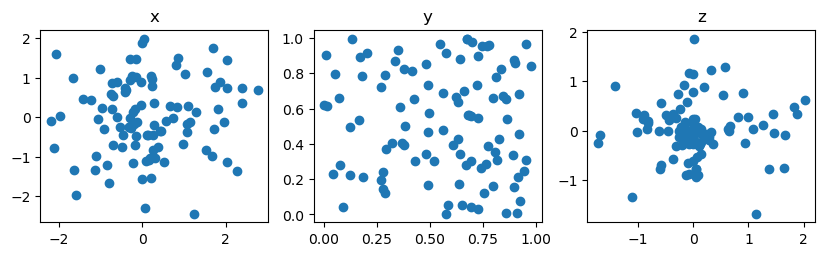

In [29]:
fig,ax = plt.subplots(1,3,figsize=(10,2.5))

ax[0].scatter(*x.T)
ax[1].scatter(*y.T)
ax[2].scatter(*z.T)

ax[0].set_title('x')
ax[1].set_title('y')
ax[2].set_title('z')

### 2b) Interactive Q: Incidence Matrix calculation <a name='inc-mat'>

In [30]:
N=10
1-np.eye(N)

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]])

In [31]:
# Also works! 
# Cute use of dtypes and masks 
(~ np.eye(N).astype(bool)).astype(int)

array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])

**Elementwise multiplication**

In [32]:
x = np.array([[1, 2],
              [3, 4],
              [5, 6]])

y = np.array([[0.1,    2 ],
              [0.1,    4 ],
              [0.01, 0.02] ])

x*y

array([[ 0.1 ,  4.  ],
       [ 0.3 , 16.  ],
       [ 0.05,  0.12]])

### 2c) Indexing  <a name="index">

**1. Integer index**

In [33]:
b

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [34]:
b[0]

0

In [35]:
b[4]

4

In [36]:
len(b)

10

In [37]:
b[10] # index from 0, last element is len(b) - 1

IndexError: index 10 is out of bounds for axis 0 with size 10

**2. Index slicing**

- Can retrieve a slice of indices via: `start: stop : step`
- Note, you can specify more than one dimension with separate slice dimensions, you just need to make sure you specify the left most dimension

In [38]:
b[1::2]

array([1, 3, 5, 7, 9])

In [39]:
b[1:9:2]

array([1, 3, 5, 7])

^ Note, when you specify `stop` the maximum end point is not included, so that you can let this be len(arr), e.g:

In [40]:
b[1:10:2]

array([1, 3, 5, 7, 9])

In [41]:
# Reverse the order <- I use this _all_ the time :D
b[::-1]

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

In [42]:
# Slicing in multiple dimensions
M = np.array([[1, 2, 3, 4], 
              [5, 6, 7, 8], 
              [9,10,11,12]])

M[1:,2:]

array([[ 7,  8],
       [11, 12]])

**3. By mask**

In [43]:
b[b%3 == 0]

array([0, 3, 6, 9])

In [44]:
M[M > 6]

array([ 7,  8,  9, 10, 11, 12])

**Integrating these ideas...** Ex from CS231n numpy [tutorial](https://cs231n.github.io/python-numpy-tutorial/)

In [45]:
# Create a new array from which we will select elements
A = np.array([[1,2,3], 
              [4,5,6], 
              [7,8,9], 
              [10, 11, 12]])

# Create an array of indices
col_idx = np.array([0, 2, 0, 1])

# Select one element from each row of a using the indices in b
A[np.arange(4), col_idx]

array([ 1,  6,  7, 11])

In [46]:
# Mutate one element from each row of a using the indices in b
A[np.arange(4), col_idx] += 10
A

array([[11,  2,  3],
       [ 4,  5, 16],
       [17,  8,  9],
       [10, 21, 12]])

### 2d) Filter maps <a name="filters">

In [47]:
from PIL import Image

In [48]:
# Open the image and store in a numpy array
img = np.asarray( Image.open('data/baboon.jpg') )

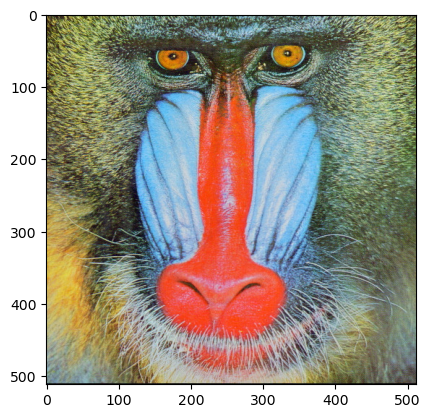

In [49]:
plt.imshow(img)
plt.show()

In [102]:
img.shape

(512, 512, 3)

This is an RGB image, so let's plot each of these channels individually

**TO DO:** In lecture

### 2e) Solve the code <a name="guess-who">
 Examples of usecases... images

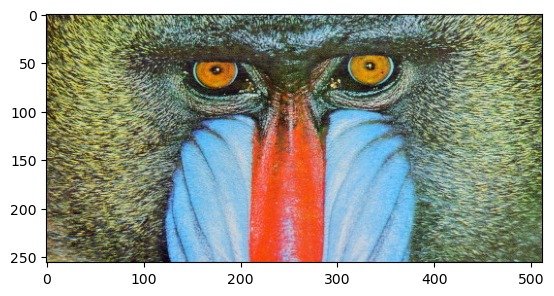

In [110]:
plt.imshow(           )
plt.show()

## 3. Broadcasting <a name="broadcast">

### 3a) Intro <a name='bintro'>
    
You can broadcast two arrays if the dimensions are
- Either equal, or
- One of them is 1

In [50]:
q = np.random.randn(100,5,2)

In [55]:
mu_q = np.mean(q,axis=1,keepdims=True)
std_q = np.std(q,axis=1,keepdims=True)

**When is the 1 inferred?**

If one array is smaller the comparison starts from the right.

In [56]:
z = (q - mu_q) / std_q

z.shape

(100, 5, 2)

In [58]:
c = np.array([1,3])

out = q / c
out.shape

(100, 5, 2)

### 3b)  Ex of when this can be challenging  <a name="bex">

A.k.a, when does broadcasting _not_ work?
  
Create some _toy data_ for an example problem that had come up in my research.

In [59]:
m = 25 * np.random.exponential(10,int(5e4))

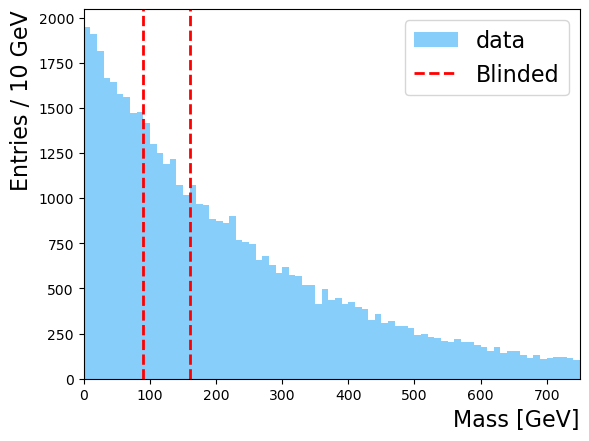

In [60]:
h, e, _ = plt.hist(m,75,(0,750),color='lightskyblue',label='data')

plt.xlabel('Mass [GeV]',loc='right',fontsize=16)
plt.ylabel('Entries / 10 GeV',loc='top',fontsize=16)
plt.xlim(0,750)

ylim = plt.ylim()

dx = 35
x_min = 125-dx
x_max = 125+dx
for xi in [x_min,x_max]:
    plt.plot([xi]*2, ylim, 'r--',lw=2,label='Blinded' if xi < 125 else None)
plt.ylim(ylim)

plt.legend(fontsize=16)

**Research Q:** Can we infer X in the expected events in the blinded region using the unblinded events?

In [61]:
len(e) # These are the edges of the histogram, so one more than the # of data points

76

In [62]:
x_mid = 0.5 * (e[1:] + e[:-1])

In [63]:
x_mid

array([  5.,  15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95., 105.,
       115., 125., 135., 145., 155., 165., 175., 185., 195., 205., 215.,
       225., 235., 245., 255., 265., 275., 285., 295., 305., 315., 325.,
       335., 345., 355., 365., 375., 385., 395., 405., 415., 425., 435.,
       445., 455., 465., 475., 485., 495., 505., 515., 525., 535., 545.,
       555., 565., 575., 585., 595., 605., 615., 625., 635., 645., 655.,
       665., 675., 685., 695., 705., 715., 725., 735., 745.])

In [64]:
x_min,x_max

(90, 160)

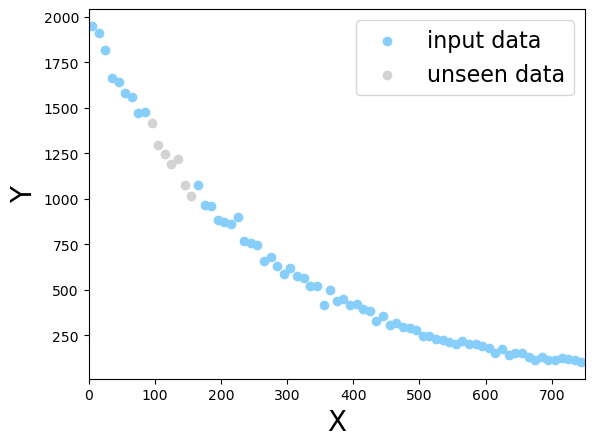

In [65]:
mask = (x_mid < x_min) | (x_mid > x_max)

plt.scatter(x_mid[mask],h[mask],color='lightskyblue',label='input data')
plt.scatter(x_mid[~mask],h[~mask],color='lightgrey',label='unseen data')

plt.xlabel('X',fontsize=20)
plt.ylabel('Y',fontsize=20)
plt.xlim(e[[0,-1]])

plt.legend(fontsize=16)

plt.show()

In [66]:
'''
This code block is not needed for this course, just treat it like a black box
for the interactive question that we have
'''

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = RBF(length_scale=10.0, length_scale_bounds=(5,300))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=.001*np.sqrt(h[mask]))

gp.fit(x_mid[mask].reshape(-1,1), h[mask])

xx = np.linspace(*e[[0,-1]]).reshape(-1,1)
yy = gp.predict(xx)

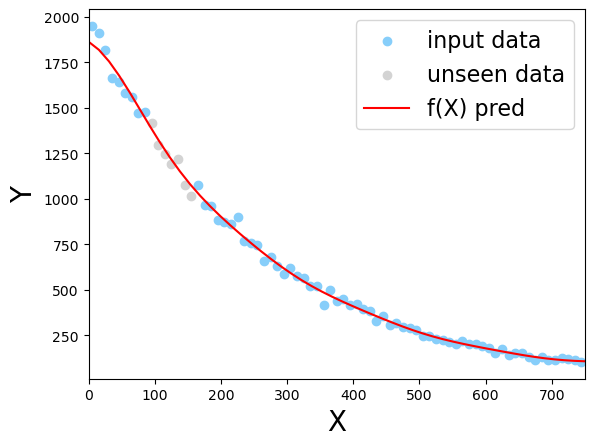

In [67]:
plt.scatter(x_mid[ mask],h[mask],color='lightskyblue',label='input data')
plt.scatter(x_mid[~mask],h[~mask],color='lightgrey',label='unseen data')

plt.plot(xx,yy,'r',label='f(X) pred')

plt.xlabel('X',fontsize=20)
plt.ylabel('Y',fontsize=20)
plt.xlim(e[[0,-1]])

plt.legend(fontsize=16)

plt.show()

In [68]:
xx.shape

(50, 1)

In [69]:
yy.shape

(50,)

In [70]:
(yy/xx).shape

/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_44766/1957213540.py:1: RuntimeWarning: divide by zero encountered in divide
  (yy/xx).shape


(50, 50)

In [71]:
(yy / xx).shape

/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_44766/375042796.py:1: RuntimeWarning: divide by zero encountered in divide
  (yy / xx).shape


(50, 50)

In [72]:
yy.shape

(50,)

In [73]:
xx.shape

(50, 1)

In [74]:
yy.shape

(50,)

In [75]:
(yy / xx).shape

/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_44766/375042796.py:1: RuntimeWarning: divide by zero encountered in divide
  (yy / xx).shape


(50, 50)

### 3c) Reshaping <a name="reshape">

A.k.a, how to _solve_ this problem.

In [76]:
yy[:,np.newaxis].shape

(50, 1)

In [77]:
yy[:,None].shape

(50, 1)

In [78]:
yy.reshape(-1,1).shape

(50, 1)

Although, for this problem we also could solve by just taking out this pesky -1 dimension

In [79]:
xx.squeeze().shape

(50,)

In [80]:
xx[:,0].shape

(50,)

In [81]:
# Or force the broadcasting to be along the dims we care about
xx.T.shape

(1, 50)

But just to motivate you not to forget about these awesome `np.newaxes` and `None` slice cmds:

**Here with the broadcasting example from the `np` [documenation](https://numpy.org/doc/stable/user/basics.broadcasting.html)**

In [82]:
a = np.array([[0,0,0],
              [10]*3,
              [20]*3,
              [30]*3])
a

array([[ 0,  0,  0],
       [10, 10, 10],
       [20, 20, 20],
       [30, 30, 30]])

In [83]:
a.shape

(4, 3)

In [84]:
b = np.arange(1,5)
b

array([1, 2, 3, 4])

In [85]:
a + b

ValueError: operands could not be broadcast together with shapes (4,3) (4,) 

In [86]:
a + b[:,np.newaxis]

array([[ 1,  1,  1],
       [12, 12, 12],
       [23, 23, 23],
       [34, 34, 34]])

## 4. Concatenation <a name="concat">
    
### 4a) Stacking nd-arrays (n>=2) <a name="nd-stack">

<img src="figures/3d-arr-img.png" width=650pt />
    
Let's go back to our <3 baboon image!

In [87]:
img.shape

(512, 512, 3)

**TO DO:** Look at the output of the following
- `np.vstack`
- `np.hstack`
- `np.dstack`

In [93]:
X_h = 

In [91]:
plt.imshow(X_h)

In [94]:
X_v = 

In [95]:
plt.imshow(X_v)

In [96]:
X_d = 

In [100]:
for i in range(3):
    X_cat = np.concatenate 
    print(f'axis={i}: {X_cat.shape}')

### 4b) Stacking vectors <a name='1d-stack'>

The way these functions with for vectors is a little bit of a np "gotcha", with the correspondence between the `np.{h,v}stack` and `np.concatenate` changing a bit for the 1d case, working out the details below.

In [102]:
v = np.arange(4)

In [103]:
np.vstack([v]*3)

array([[0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3]])

In [104]:
np.hstack([v]*3)

array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])

In [105]:
# same as np.vstack
np.concatenate([v[None,:]]*3,axis=0)

array([[0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3]])

In [106]:
# same as np.hstack
np.concatenate([v]*3,axis=0)

array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])

##  5. Sorting functions <a name="sort">
    
### 5a) Value sort <a name="min-max">

- `np.min`
- `np.max`
- `np.sort`

In [107]:
N,d = 10,3
X = np.random.randn(N,d)

In [108]:
X.min()

-2.615760921801395

In [109]:
X.min(axis=0)

array([-1.67915474, -2.61576092, -1.27724956])

In [110]:
# equivalent to 
np.min(X, axis=0)

array([-1.67915474, -2.61576092, -1.27724956])

^ Same synax for np.max

`np.sort` sorts along `dim = -1` **in descending order**

In [111]:
np.sort(X)

array([[-0.90210311, -0.06710462,  0.29752325],
       [-1.27724956,  0.52541379,  1.73316735],
       [ 0.81689594,  0.95992119,  1.6314022 ],
       [-1.67915474, -0.59171872, -0.26425847],
       [-0.54889679, -0.02811648,  0.12277219],
       [-1.29960897, -0.41897199,  0.3564328 ],
       [-0.67615384, -0.40080719,  1.38653053],
       [-1.13608832, -0.80675943,  0.1607377 ],
       [-2.61576092,  0.70320979,  1.17647189],
       [-0.90688241, -0.14151354,  1.37698459]])

Can specify another dim to do the sort along! 

In [112]:
np.sort(X,axis=0)

array([[-1.67915474, -2.61576092, -1.27724956],
       [-0.90210311, -1.29960897, -1.13608832],
       [-0.54889679, -0.80675943, -0.90688241],
       [-0.40080719, -0.59171872, -0.67615384],
       [-0.14151354, -0.06710462, -0.41897199],
       [ 0.1607377 , -0.02811648, -0.26425847],
       [ 0.3564328 ,  0.52541379,  0.12277219],
       [ 0.81689594,  0.95992119,  0.29752325],
       [ 1.17647189,  1.37698459,  0.70320979],
       [ 1.73316735,  1.38653053,  1.6314022 ]])

### 5b) Arg sort <a name="arg-dim-1">

Can accomplish the same things with `np.arg{min,max,sort}`

In [113]:
i_min = np.argmin(X)
i_min

25

In [114]:
X.flatten()[i_min],np.min(X)

(-2.615760921801395, -2.615760921801395)

^ They match!

In [115]:
iarr_min = np.argmin(X,axis=0)
iarr_min

array([3, 8, 1])

In [116]:
X.shape

(10, 3)

As this `iarr_min` specifies the rows, then we also need to explicity specify the cols.

In [117]:
X[iarr_min,np.arange(d)] 

array([-1.67915474, -2.61576092, -1.27724956])

In [118]:
np.min(X,axis=0)

array([-1.67915474, -2.61576092, -1.27724956])

Sanity check passed :)

### 5c) Interactive example <a name="arg-dim-0">

with the arg sorting, but now along a different axis!

In [119]:
# sorting along dim 1
i1 = np.argsort(X)
i1

array([[0, 1, 2],
       [2, 1, 0],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [1, 2, 0],
       [2, 0, 1],
       [2, 1, 0],
       [1, 2, 0],
       [2, 0, 1]])

In [120]:
X[np.arange(N)[:,None],i1]

array([[-0.90210311, -0.06710462,  0.29752325],
       [-1.27724956,  0.52541379,  1.73316735],
       [ 0.81689594,  0.95992119,  1.6314022 ],
       [-1.67915474, -0.59171872, -0.26425847],
       [-0.54889679, -0.02811648,  0.12277219],
       [-1.29960897, -0.41897199,  0.3564328 ],
       [-0.67615384, -0.40080719,  1.38653053],
       [-1.13608832, -0.80675943,  0.1607377 ],
       [-2.61576092,  0.70320979,  1.17647189],
       [-0.90688241, -0.14151354,  1.37698459]])

Visually, look good, but let's double check to be sure!

In [121]:
np.all(X[np.arange(N)[:,None],i1] == np.sort(X))

True

Wooooo!! And now for the other dim :)

In [122]:
i0 = np.argsort(X, axis=0)

In [123]:
i0

array([[3, 8, 1],
       [0, 5, 7],
       [4, 7, 9],
       [6, 3, 6],
       [9, 0, 5],
       [7, 4, 3],
       [5, 1, 4],
       [2, 2, 0],
       [8, 9, 8],
       [1, 6, 2]])

**TO DO:** What to make?

In [127]:
X [] # what to mask?

In [126]:
# np.all

### 6d) Eample: HH -> 4b <a name="hh4b">

<img src="figures/HH4b-evt-display.png"
     width=650pt />

Suppose you have 4 $b$-jets (as indicated by the yellow cones in this picture)

Example application: 
- We want correction factors for the data aquisition process 
    - Or in jargon, applying scale factors for $b$-jet triggers
- To apply this, we need the $3^{rd}$ highest momentum jet in the event
- See section 5 (first paragraph) of recent ATLAS paper [2301.03212](https://arxiv.org/pdf/2301.03212.pdf), (and my PhD thesis)!

We'll make some toy data to make a simulated application for this example, but the solution should directly translate over to your (data) scientist life!!

In [128]:
nEx = 10_000
njets = 4 

# each example (dim 0) saves the jet (dim 1) 
# with the pt, eta, phi, E (dim 2)
X_4v = np.zeros((nEx, njets, 4))

In [129]:
'''
Setup to get toy kinematics similar to HH->4b kinematics
'''

# Transverse momentum
log_pt = np.random.randn(nEx,njets)
X_4v[:,:,0] = np.exp(3.75 + log_pt * 1.15)

# eta: angular variable "pseudo-rapidity"
# Note: Lorentz boosts along the z-axis ~ are additive in eta
# Clip at 2.5 b/c the tracking detector only extends to |eta| = 2.5
eta = 0.9 * np.random.randn(nEx,njets)
X_4v[:,:,1] = np.clip(eta, -2.5, 2.5)

# phi: azimuthal variable
phi = np.random.uniform(low=-np.pi, high=np.pi, size=(nEx,njets))
X_4v[:,:,2] =phi 

# energy
log_E = np.random.randn(nEx,njets)
X_4v[:,:,3] = np.exp(4.5 + log_E)

**OK, now return the vector `X_sort` such that the jets are ordered by pt with the leading jet $p_T$ first**

In [130]:
np.argsort?

In [131]:
idx = np.argsort(X_4v[:,:,0], axis=1)[:,::-1]
idx.shape

(10000, 4)

In [132]:
X_sort = 

**Sanity checks:**
- Does the output have the right shape

In [133]:
# X_sort.shape

- Does the first event look ok?

In [134]:
# X_sort[0].round(1)

So the first column is the jet $p_T$, and yep, they are sorted in decreasing order :)

Let's double check that we actually are reshuffling all of the $(p_T, \eta, \phi, E)$ for each jet and not only the $p_T$s!

In [135]:
# X_4v[0].round(1)

In [136]:
# idx[0]

- Does a random event also look ok?

In [654]:
# 


array([[ 4.896e+02,  1.100e+00, -2.300e+00,  2.613e+02],
       [ 1.403e+02, -4.000e-01, -6.000e-01,  1.622e+02],
       [ 1.830e+01, -2.000e-01,  1.000e+00,  4.240e+01],
       [ 7.900e+00, -2.000e-01, -1.400e+00,  1.808e+02]])

Let's plot histograms for the jets sorted by $p_T$ and not!

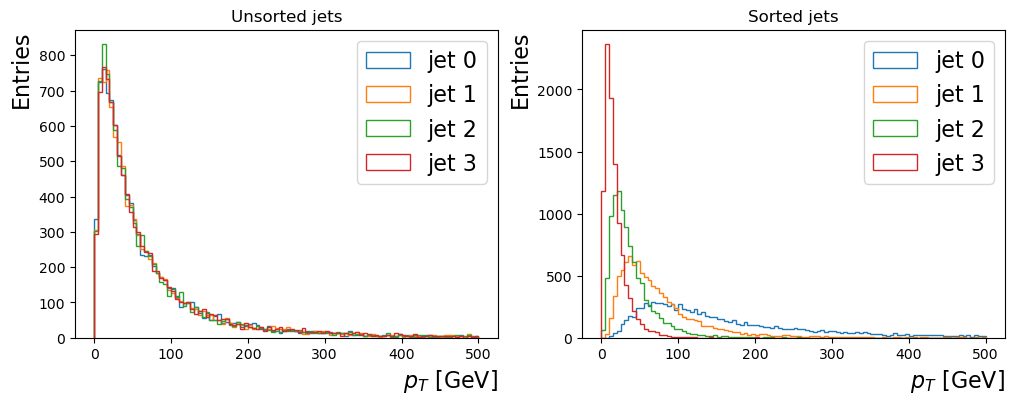

In [657]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))

nb = 100
r = (0,500)
for i in range(njets):
    ax1.hist(X_4v  [:,i,0],nb,r,label=f'jet {i}',histtype='step')
    ax2.hist(X_sort[:,i,0],nb,r,label=f'jet {i}',histtype='step')
    
for axi in [ax1,ax2]:
    axi.set_xlabel('$p_T$ [GeV]',loc='right',fontsize=16)  
    axi.set_ylabel('Entries',loc='top',fontsize=16)  
    axi.legend(fontsize=16)

ax1.set_title('Unsorted jets')  
ax2.set_title('Sorted jets')  
plt.show()

## 6. Aggregator functions <a name="agg">

### 6a) Mean / std / sum <a name='agg-mean'>
    
- `np.mean` 
- `np.std` 
- `np.sum`

Let's stick with the same image we've been having a lot of fun with today!

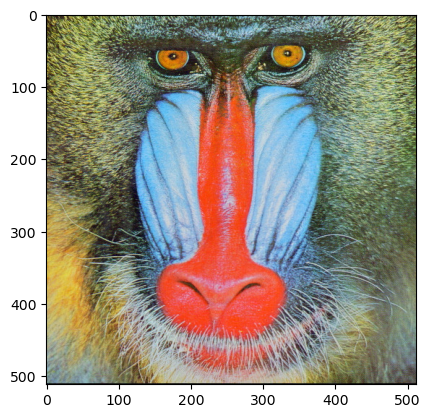

In [137]:
plt.imshow(img)

What's the distribution of pixel intensities over the image?

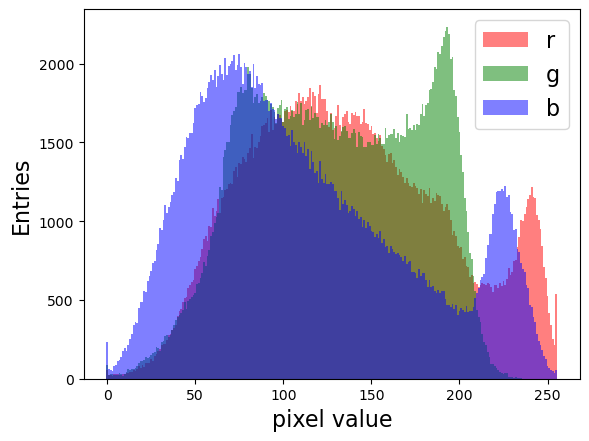

In [138]:
for i,c in enumerate(['r','g','b']):
    plt.hist(img[:,:,i].flatten(),256,(-.5,255.5),color=c,alpha=.5,label=c)
plt.xlabel('pixel value',fontsize=16)
plt.ylabel('Entries',fontsize=16)
plt.legend(fontsize=16)
plt.show()

- Blue and red most noticably have strong double peaked structure, b/c the image has around the nose some strong blue and red coloring, but more generally, less blue and red in the imag
- The green is less sharply peaked at very large or small pixel intensities, and has the smallest spread of all of the filters

**Let's watch this intuition get reflected in the mean and std** 

In [139]:
?np.mean

In [140]:
np.mean(img,axis=(0,1)).round(2)

array([137.07, 129.15, 112.86])

In [141]:
np.std(img,axis=(0,1)).round(2)

array([55.5 , 47.49, 60.61])

What if we take the mean over the pixels? 

Can you guess what the answer will look like?

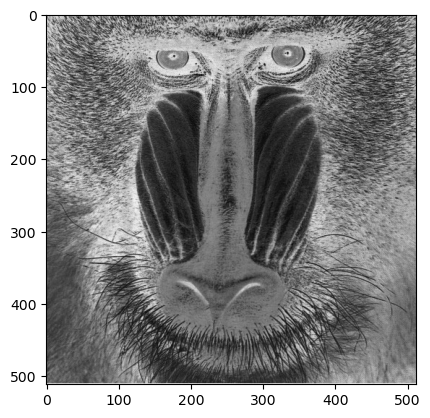

In [142]:
img_g = np.mean(img,axis=2)
plt.imshow(img_g,cmap='binary')

What happens when we try to take the ratio of the OG image over this average?

In [143]:
img / img_g

ValueError: operands could not be broadcast together with shapes (512,512,3) (512,512) 

**Two solns:**

1. Use our handy dandy "insert new axis" trick 

In [144]:
img / img_g[:,:,None]

/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_44766/4034566423.py:1: RuntimeWarning: invalid value encountered in divide
  img / img_g[:,:,None]


array([[[1.16788321, 1.09489051, 0.73722628],
        [1.47916667, 1.27083333, 0.25      ],
        [1.69306931, 1.30693069, 0.        ],
        ...,
        [1.27424749, 1.20401338, 0.52173913],
        [1.095     , 1.23      , 0.675     ],
        [1.03941909, 1.21369295, 0.74688797]],

       [[1.34482759, 1.15862069, 0.49655172],
        [1.31316726, 1.1316726 , 0.55516014],
        [1.5       , 1.175     , 0.325     ],
        ...,
        [0.98641304, 1.16576087, 0.84782609],
        [1.00478469, 1.12679426, 0.86842105],
        [1.01123596, 1.14606742, 0.84269663]],

       [[1.5       , 1.36082474, 0.13917526],
        [1.28282828, 1.17171717, 0.54545455],
        [1.48739496, 1.08403361, 0.42857143],
        ...,
        [1.14084507, 1.08802817, 0.77112676],
        [1.20746888, 1.07053942, 0.7219917 ],
        [1.25892857, 1.04464286, 0.69642857]],

       ...,

       [[0.84705882, 1.06588235, 1.08705882],
        [0.85613208, 1.08254717, 1.06132075],
        [0.86697248, 1

2. The `np.mean` and `np.std` also let you keep the dimensions, for exactly this purpose (and maybe the ubiquity of this type of preprocessing over the range of inputs in ML applicaitons).

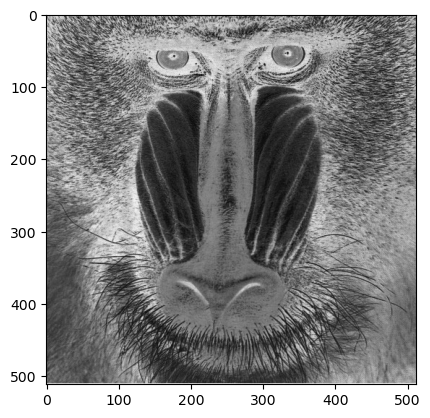

In [145]:
img_g2 = np.mean(img,axis=2,keepdims=True)
plt.imshow(img_g2,cmap='binary')

In [146]:
img_g2.shape

(512, 512, 1)

In [147]:
img / img_g2

/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_44766/2117385137.py:1: RuntimeWarning: invalid value encountered in divide
  img / img_g2


array([[[1.16788321, 1.09489051, 0.73722628],
        [1.47916667, 1.27083333, 0.25      ],
        [1.69306931, 1.30693069, 0.        ],
        ...,
        [1.27424749, 1.20401338, 0.52173913],
        [1.095     , 1.23      , 0.675     ],
        [1.03941909, 1.21369295, 0.74688797]],

       [[1.34482759, 1.15862069, 0.49655172],
        [1.31316726, 1.1316726 , 0.55516014],
        [1.5       , 1.175     , 0.325     ],
        ...,
        [0.98641304, 1.16576087, 0.84782609],
        [1.00478469, 1.12679426, 0.86842105],
        [1.01123596, 1.14606742, 0.84269663]],

       [[1.5       , 1.36082474, 0.13917526],
        [1.28282828, 1.17171717, 0.54545455],
        [1.48739496, 1.08403361, 0.42857143],
        ...,
        [1.14084507, 1.08802817, 0.77112676],
        [1.20746888, 1.07053942, 0.7219917 ],
        [1.25892857, 1.04464286, 0.69642857]],

       ...,

       [[0.84705882, 1.06588235, 1.08705882],
        [0.85613208, 1.08254717, 1.06132075],
        [0.86697248, 1

### 7b) ROC curves <a name="roc">

**Speaking of sums...** what's another use case for summation, or numerical integration?

Often in ML we make ROC curves (Receiver Operator Characteristic) to characterize the performance of a tagger as signal efficiency verus backround mis-ID efficiency.

Let's build our intution by coding this up!

In [148]:
# Build a training dataset with some images from two Gaussians
# and providing some truth labels

nEx = int(1e5)

x_0 = -1  + np.random.randn(nEx)
x_1 = 1.5 + np.random.randn(nEx)

y_0 = np.zeros_like(x_0)
y_1 = np.ones_like(y_0)

**Concatenate the arrays and _shuffle_ the training data points**

In [149]:
x = np.hstack([x_0,x_1])
y = np.hstack([y_0,y_1])

i_shuf = np.random.permutation(np.arange(len(x)))

x = x[i_shuf]
y = y[i_shuf]

**Look at the histograms:**

(-4.0, 5.0)

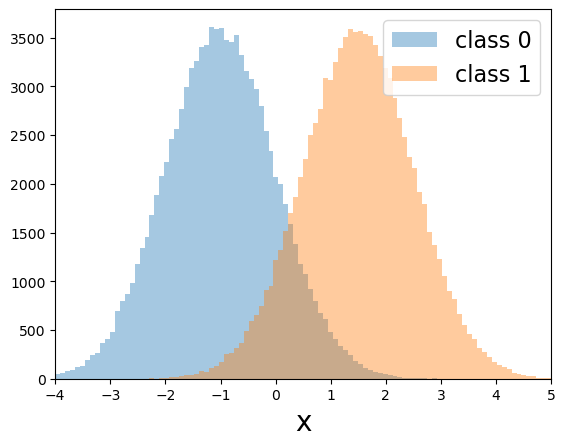

In [150]:
nb = 100
r = (-4,5)

hist_list = []

for i in range(2):
    hist, bin_edges, _ = plt.hist(x[y==i],nb,r,alpha=.4,label=f'class {i}')
    hist_list.append(hist)
    
plt.xlabel('x',fontsize=20)
plt.legend(fontsize=16)
plt.xlim(r)

Something we've kind of been dancing around for awhile in this notebook is making plots with the `plt.hist` function.

Later in the class, we'll have whole dedicated lecutres and tutorials on visualization, so for now, we just want to make teh connnection that `plt.hist` is just a wrapper around the `np.histogram` function.

### `np.histogram`

**Inputs:**
- `vals`: The entries to be binned
- `bins`: the # of bins (i.e, `N`)
- `range`: tuple for (min,max) 

Note, alternatively, `bins` can be array like specifying the bin_edges (`N+1` entries for a hist with `N` bins), and then the `range` arg will not be used.

**Outputs:**
- `hist`: the bin entries (len N, N the # of bins)
- `bin_edges`: bin edges from r[0], r[-1], with len N+1

Furthermore, note there are also analogous
- `np.histogram2d`
- `np.histogramdd`
for higher dimensional histograms.

**And now draw the ROC curves**

The key function here is `np.add.accumulate`.

In [227]:
?np.add.accumulate

Text(0.5, 1.0, 'ROC curve')

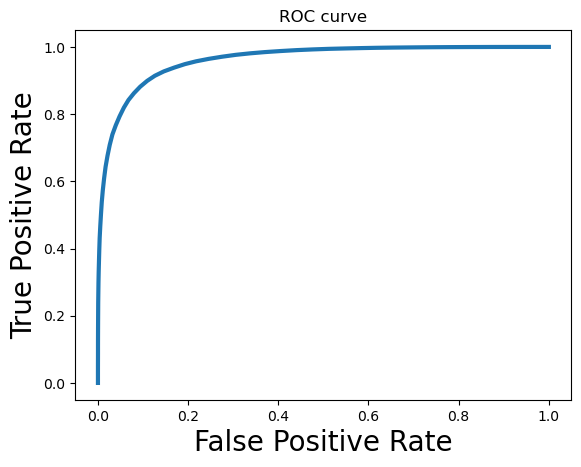

In [228]:
h0, h1 = hist_list

cum_sum0 = np.add.accumulate( h0[::-1] / np.sum(h0) )
cum_sum1 = np.add.accumulate( h1[::-1] / np.sum(h1) )

plt.plot(cum_sum0,cum_sum1,lw=3)

plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('ROC curve')

### 7c) Numerical Differentiation <a name="num-diff">

**App 1:** Edge detection

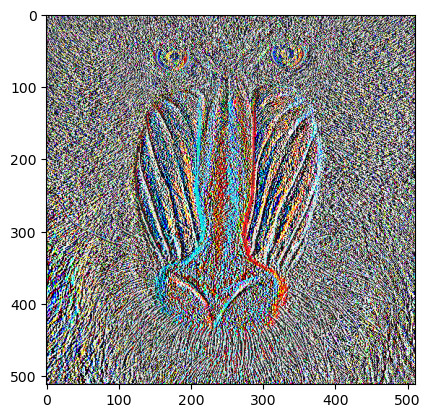

In [804]:
plt.imshow( img[:,1:] - img[:,:-1] )
plt.show()

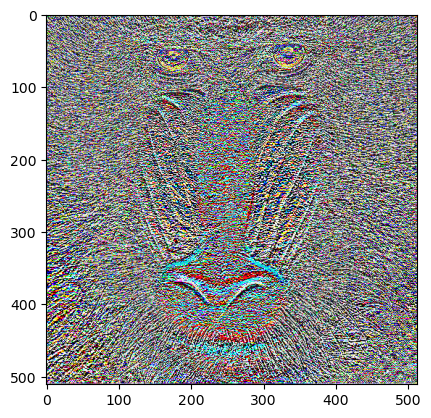

In [805]:
plt.imshow( img[1:] - img[:-1] )
plt.show()

**App 2:** Bin widths

In [834]:
len(e)

76

(0.0, 750.0)

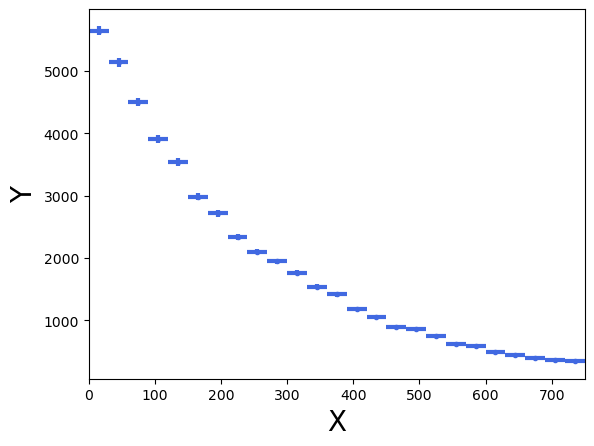

In [841]:
h2, e2 = np.histogram(m,25,(0,750))

x2 = 0.5 * ( e2[1:] + e2[:-1] )
dw = 0.5 * ( e2[1:] - e2[:-1] )

plt.errorbar(x2, h2, np.sqrt(h2), dw, color='royalblue',marker='.',lw=0,elinewidth=3)
plt.xlabel('X',fontsize=20)
plt.ylabel('Y',fontsize=20)
plt.xlim(e[[0,-1]])


## 7. Linear Algebra <a name="linalg">

### 7a) Matrix multiplication <a name="matmul">

Let's explore the syntax in numpy with a rotation in a 2d coordinate system.

Recall, in 2d a rotation by angle $\theta$ is specified by

$$Q = \begin{pmatrix}
\cos \theta \  &-\sin \theta \\
\sin \theta \ &\cos \theta
\end{pmatrix}
$$

In [121]:
X = np.array([[1, 0],
              [0, 1]])
X

array([[1, 0],
       [0, 1]])

In [116]:
# this is an inline function that defines the 2d matrix for an arbitrary theta
Q_th = lambda theta: np.array([[np.cos(theta), - np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

In [117]:
# Let's test multiplying by 30 degrees, or pi/6 rad
Q = Q_th(np.pi / 6)

In [120]:
Q @ X

array([[ 0.8660254, -0.5      ],
       [ 0.5      ,  0.8660254]])

But this isn't the only way to do matrix multiplication in np!

In [123]:
np.matmul(Q,X)

array([[ 0.8660254, -0.5      ],
       [ 0.5      ,  0.8660254]])

In [125]:
np.dot(Q,X)

array([[ 0.8660254, -0.5      ],
       [ 0.5      ,  0.8660254]])

### 7b) `np.einsum` <a name='einsum'>

In [130]:
# einstein notation, in explicit mode
np.einsum('ij,jk->ik',Q,X)

array([[ 0.8660254, -0.5      ],
       [ 0.5      ,  0.8660254]])

In [131]:
# einstein notation, in implicit mode
np.einsum('ij,jk',Q,X)

array([[ 0.8660254, -0.5      ],
       [ 0.5      ,  0.8660254]])

^ This `einsum` notation is super nice and powerful syntax!!

This picture from [EinSum Visualized](https://betterprogramming.pub/einsum-visualized-c050903145ef) helps show the additional power and flexibility of this notation.

<img src="figures/einsum.png"/>

### 7c) Eigen values / vectors <a name="eigval">

This is another pretty classic that comes up a lot in physics.

In [226]:
H = np.array([[1, .02],[.02, 1]])
H

array([[1.  , 0.02],
       [0.02, 1.  ]])

In [207]:
lmbda, V = np.linalg.eig(H)

- lmbda: vector of the eigen values (sorted in decreasing order)
- `V` matrix where the columns are the eigenvectors

In [208]:
lmbda

array([1.02, 0.98])

In [209]:
V

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

Note, these eigenvectors are orthogonal:

In [210]:
V[:,0] @ V[:,1]

0.0

In [217]:
lmbda[0] *  V[:,0][:,None] @ V[:,0][None]

array([[0.51, 0.51],
       [0.51, 0.51]])

In [222]:
V @ np.diag(lmbda) @ V.T

array([[1.  , 0.02],
       [0.02, 1.  ]])

In [224]:
# But can also get this by summing up the individual components
lmbda[0] *  V[:,0][:,None] @ V[:,0][None] +  lmbda[1] *  V[:,1][:,None] @ V[:,1][None] 

array([[1.  , 0.02],
       [0.02, 1.  ]])

For more useful functions, refer to the (excellent) [np.linalg](https://numpy.org/doc/stable/reference/routines.linalg.html) and [np](https://numpy.org/doc/stable/index.html) documentation.

**Other useful resources:**
- CS231n [python / np tutorial](https://cs231n.github.io/python-numpy-tutorial/)
- Jim Pavarski's [numpy tutorial](https://github.com/jpivarski-talks/python-numpy-mini-course)